In [222]:
import numpy as np
import matplotlib.pyplot as plt

In [223]:
# Example function for a quadratic equation for visualizing the gradient descent

def f(x):
    return 3*x**2 - 4*x + 5

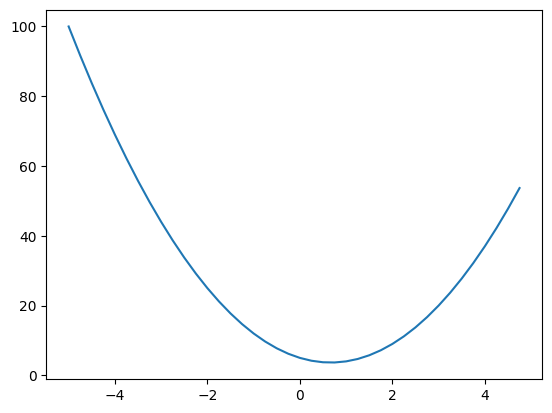

In [224]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

plt.plot(xs,ys)

In [225]:
# To understand the concept of derivation, we change the  of x by a tiny amount h and normalize over h. AKA rise over run

h=0.000000000000001
x=3.0
df=(f(x+h)-f(x))/h
print(df)

10.658141036401503


In [226]:
# The class below is a fundamental object of the program which helps us define nodes for the graph with operations or gradient and data

import math


class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self.grad = 0.0
        self._backward = lambda: None
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        # The line below will allow us to add numbers to value objects without having to convert them into Value objects: Example: Value(3.0) + 2.0 is now possible
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            # Here since we are doing an addition operation, the gradient of the output with respect to the input is proportional thus 1.0
            # Notice how we are adding the gradients, this is because if the same node is used multiple times (which it usually is), we dont want to overwrite the gradient, we want it to be additive
            # This is the same for multiplication and tanh operation as well
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out
    
    def __mul__(self, other):
        # The line below will allow us to multiply numbers to value objects without having to convert them into Value objects: Example: Value(3.0) * 2.0 is now possible
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            # Here since we are doing a multiplication operation, the gradient of the output with respect to the input is the data of the other input times the gradient of the output
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    # Now this is interesting, here we are defining the reverse multiplication operation, now we can do 2.0 * Value(3.0) as well.
    def __rmul__(self, other):
        return self.__mul__(other)

    def __radd__(self, other):
        return self.__add__(other)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self,), f'**{other}')
        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out

    def __neg__(self):  
        return self * -1.0

    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        out = Value(math.tanh(self.data), (self,), 'tanh')
        def _backward():
            self.grad += 1.0 - out.data**2 * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def topological_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topological_sort(child)
                topo.append(v)
        topological_sort(self) 
        self.grad=1.0
        for node in reversed(topo):
            node._backward()



# The next cell will represent a graph for operations of a neural net

In [227]:
from graphviz import Digraph

def trace(root):
    #builds a set of all nodesand edges in the graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
def draw_dot(root):
    
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})
    nodes, edges = trace(root)

    for n in nodes:
        uid=str(id(n))
        dot.node(name=uid, label=f"{n.label} | Data: {n.data:.4f} | Grad: {n.grad:.4f}", shape='record')

        if n._op:
            dot.node(name=uid +n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

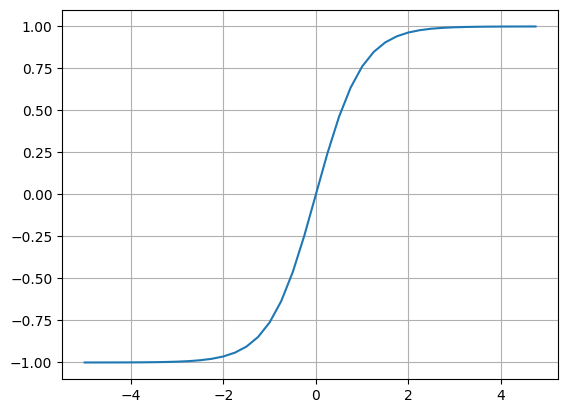

In [228]:
plt.plot(np.arange(-5, 5, 0.25), np.tanh(np.arange(-5, 5, 0.25))) 
plt.grid()

In [229]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870, label='b')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2+b; n.label = 'n'

o=n.tanh(); o.label = 'o'


In [230]:
o.backward()

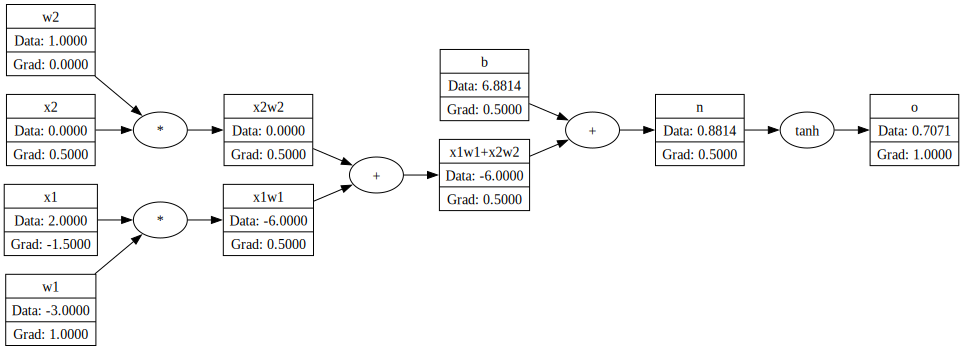

In [231]:
draw_dot(o)

In the diagram above, we can understand how the gradients are calculated.  
What is a gradient?  
A gradient represents the effect of one variable to other variable. It shows, how much you have to wiggle a variable so that the output variable will be affected.  
  
Every operation node has 2 objectives:  
1. To carry out the operation in forward pass
2. To determine the influence of data of each input node to the output node -> This is carried out by the `_backward` function in Value object


In [232]:
# Here we set the gradient of the output to 1.0 and then call the backward functions of each nodes in a reverse order so that we propogate the gradientone by one into the input nodes to find out how much each input affects the final output of the function

# o.grad = 1.0
# o._backward()
# n._backward()
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()
# w1._backward()
# w2._backward()
# x1._backward()
# x2._backward()

# Now we dont need to call this manually because we have set it up to be called automatically when we call the backward function of the output node

Next we will run these backward functions automatically so that its flexible with various different architectures of NN  
To do this we sort the graph using topological sort in which all edges go from left to right.  

<img src="https://miro.medium.com/v2/resize:fit:1400/1*uMg_ojFXts2WZSjcZe4oRQ.png" style="width:40%; height:auto"/>


This is the code which is used to perform the backpropagation in a more automated way. We first create a topological sort of the nodes in the graph and then we iterate over the nodes in a reverse order to call the backward function of each node. This way we can perform backpropagation in a more automated way.

This cell is commented out because this will be added into the functionality of the Value class 

```
o.grad=1.0
topo = []
visited = set()
def topological_sort(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            topological_sort(child)
        topo.append(v)
topological_sort(o)

for node in reversed(topo):
        node._backward()
```


The following is the pytorch representation of the code we wrote above.

In [233]:
import torch

In [234]:
# Pytorch works on tensors but has a similar concept of automatic differentiation. Here we are doing the same thing as above and we can confirm because the gradients produced by pytorch are the same.
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

# same as our value object, the pytorch tensor elements also have .data and .grad attributes.
# we use the .item function because that way we can get the value of the tensor as a python number instead of a tensor object.
print(o.data.item())
o.backward()

print('x2 =', x2.grad.item())
print('w2 =', w2.grad.item())
print('x1 =', x1.grad.item())
print('w1 =', w1.grad.item())


0.7071066904050358
x2 = 0.5000001283844369
w2 = 0.0
x1 = -1.5000003851533106
w1 = 1.0000002567688737


We have displayed the working backprop of a single neuron uptil now in our micrograd function but now we will try and implement multiple neurons and make a Neural Network. We can have multiple weights and multiply with weights etc.

In [262]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1.0, 1.0)) for _ in range(nin)]
        self.b = Value(random.uniform(-1.0, 1.0))
    def __call__(self, x):
        act = sum([wi*xi for wi, xi in zip(self.w, x)], self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)
# draw_dot(n(x))

Value(data=0.1412554029780242)

We now want to understand the concept of loss. Which is a SINGLE SCALAR which defines the performance of your network. The loss is a comparison with the predicted values of the model with the actual data.
We then continue to process backprop on this variable because this is the variable we need to minimize.

In [263]:
# This is a tiny example dataset just to show the working of loss in NNs
xs = [[2.0, 3.0, -1.0], [3.0,-1.0, 0.5], [0.5, 1.0, 1.0], [1.0, 1.0, -1.0]]
ys = [1.0, -1.0, -1.0, 1.0]


In [264]:
# We now recalculate the loss and see if it has decreased
ypred = [n(x) for x in xs]
loss = sum([(Value(y)-yhat)**2 for y, yhat in zip(ys, ypred)])
loss.backward()
ypred

[Value(data=0.1412554029780242),
 Value(data=0.21875507885707424),
 Value(data=-0.8284721306846556),
 Value(data=-0.2643918893665969)]

Now we can perform the previous tasks iteratively which will be displayed below.

In [266]:
for p in n.parameters():
    print(f"Grad: {p.grad}")


Grad: -0.031736453711910806
Grad: 0.5651573292172902
Grad: 0.20976105532799927
Grad: 1.1623078826786595
Grad: 13.7516962521895
Grad: 5.272554828051787
Grad: -0.27627336503997113
Grad: 7.133028557890475
Grad: 9.72706047672011
Grad: 3.8756149561089988
Grad: -0.022924240438536803
Grad: 5.317045729106632
Grad: 24.232894998120532
Grad: 14.208408657839385
Grad: -3.824302230781612
Grad: 13.391262970410683
Grad: -1.361820010506918
Grad: 1.3005422479576652
Grad: 1.1241096380971816
Grad: 3.47233180211897
Grad: 4.047246011825097
Grad: -2.23909848719032
Grad: 2.113650719496519
Grad: 1.5670815982253117
Grad: 4.861116311891838
Grad: 5.560833145170683
Grad: -1.6671957547858007
Grad: 1.596250416041949
Grad: 1.298993205828356
Grad: 3.875032726807132
Grad: 4.469748592331282
Grad: -1.3201006412401495
Grad: 1.2634678093044678
Grad: 1.1204054326367205
Grad: 3.4030698125107834
Grad: 3.9734004029565386
Grad: -1.768596876961223
Grad: -1.9475574418802848
Grad: -1.927678791769293
Grad: -0.42859872789996567
Grad

0 4.516110162847538
1 4.19460541990431
2 2.132902204564226
3 1.8471992861826598
4 2.7785522554388464
5 3.3887124236854245
6 6.2678749840379755
7 7.8625349009493934
8 7.985019571160098
9 7.9993471238778655
10 7.997429342168775
11 7.955775208405477
12 7.996718713189552
13 7.999603379253005
14 8.00004227739066
15 7.999973467515994
16 8.00043763379935
17 7.9999999805795525
18 7.9994637812069005
19 7.574085516223194e-10
20 7.986941599328596
21 7.999999999991289
22 7.999865883836789
23 7.999981730402748
24 7.999999999999936
25 7.9999915600558325
26 7.999998858361952
27 7.999999999999982
28 7.9999995753907704
29 7.999999963752302


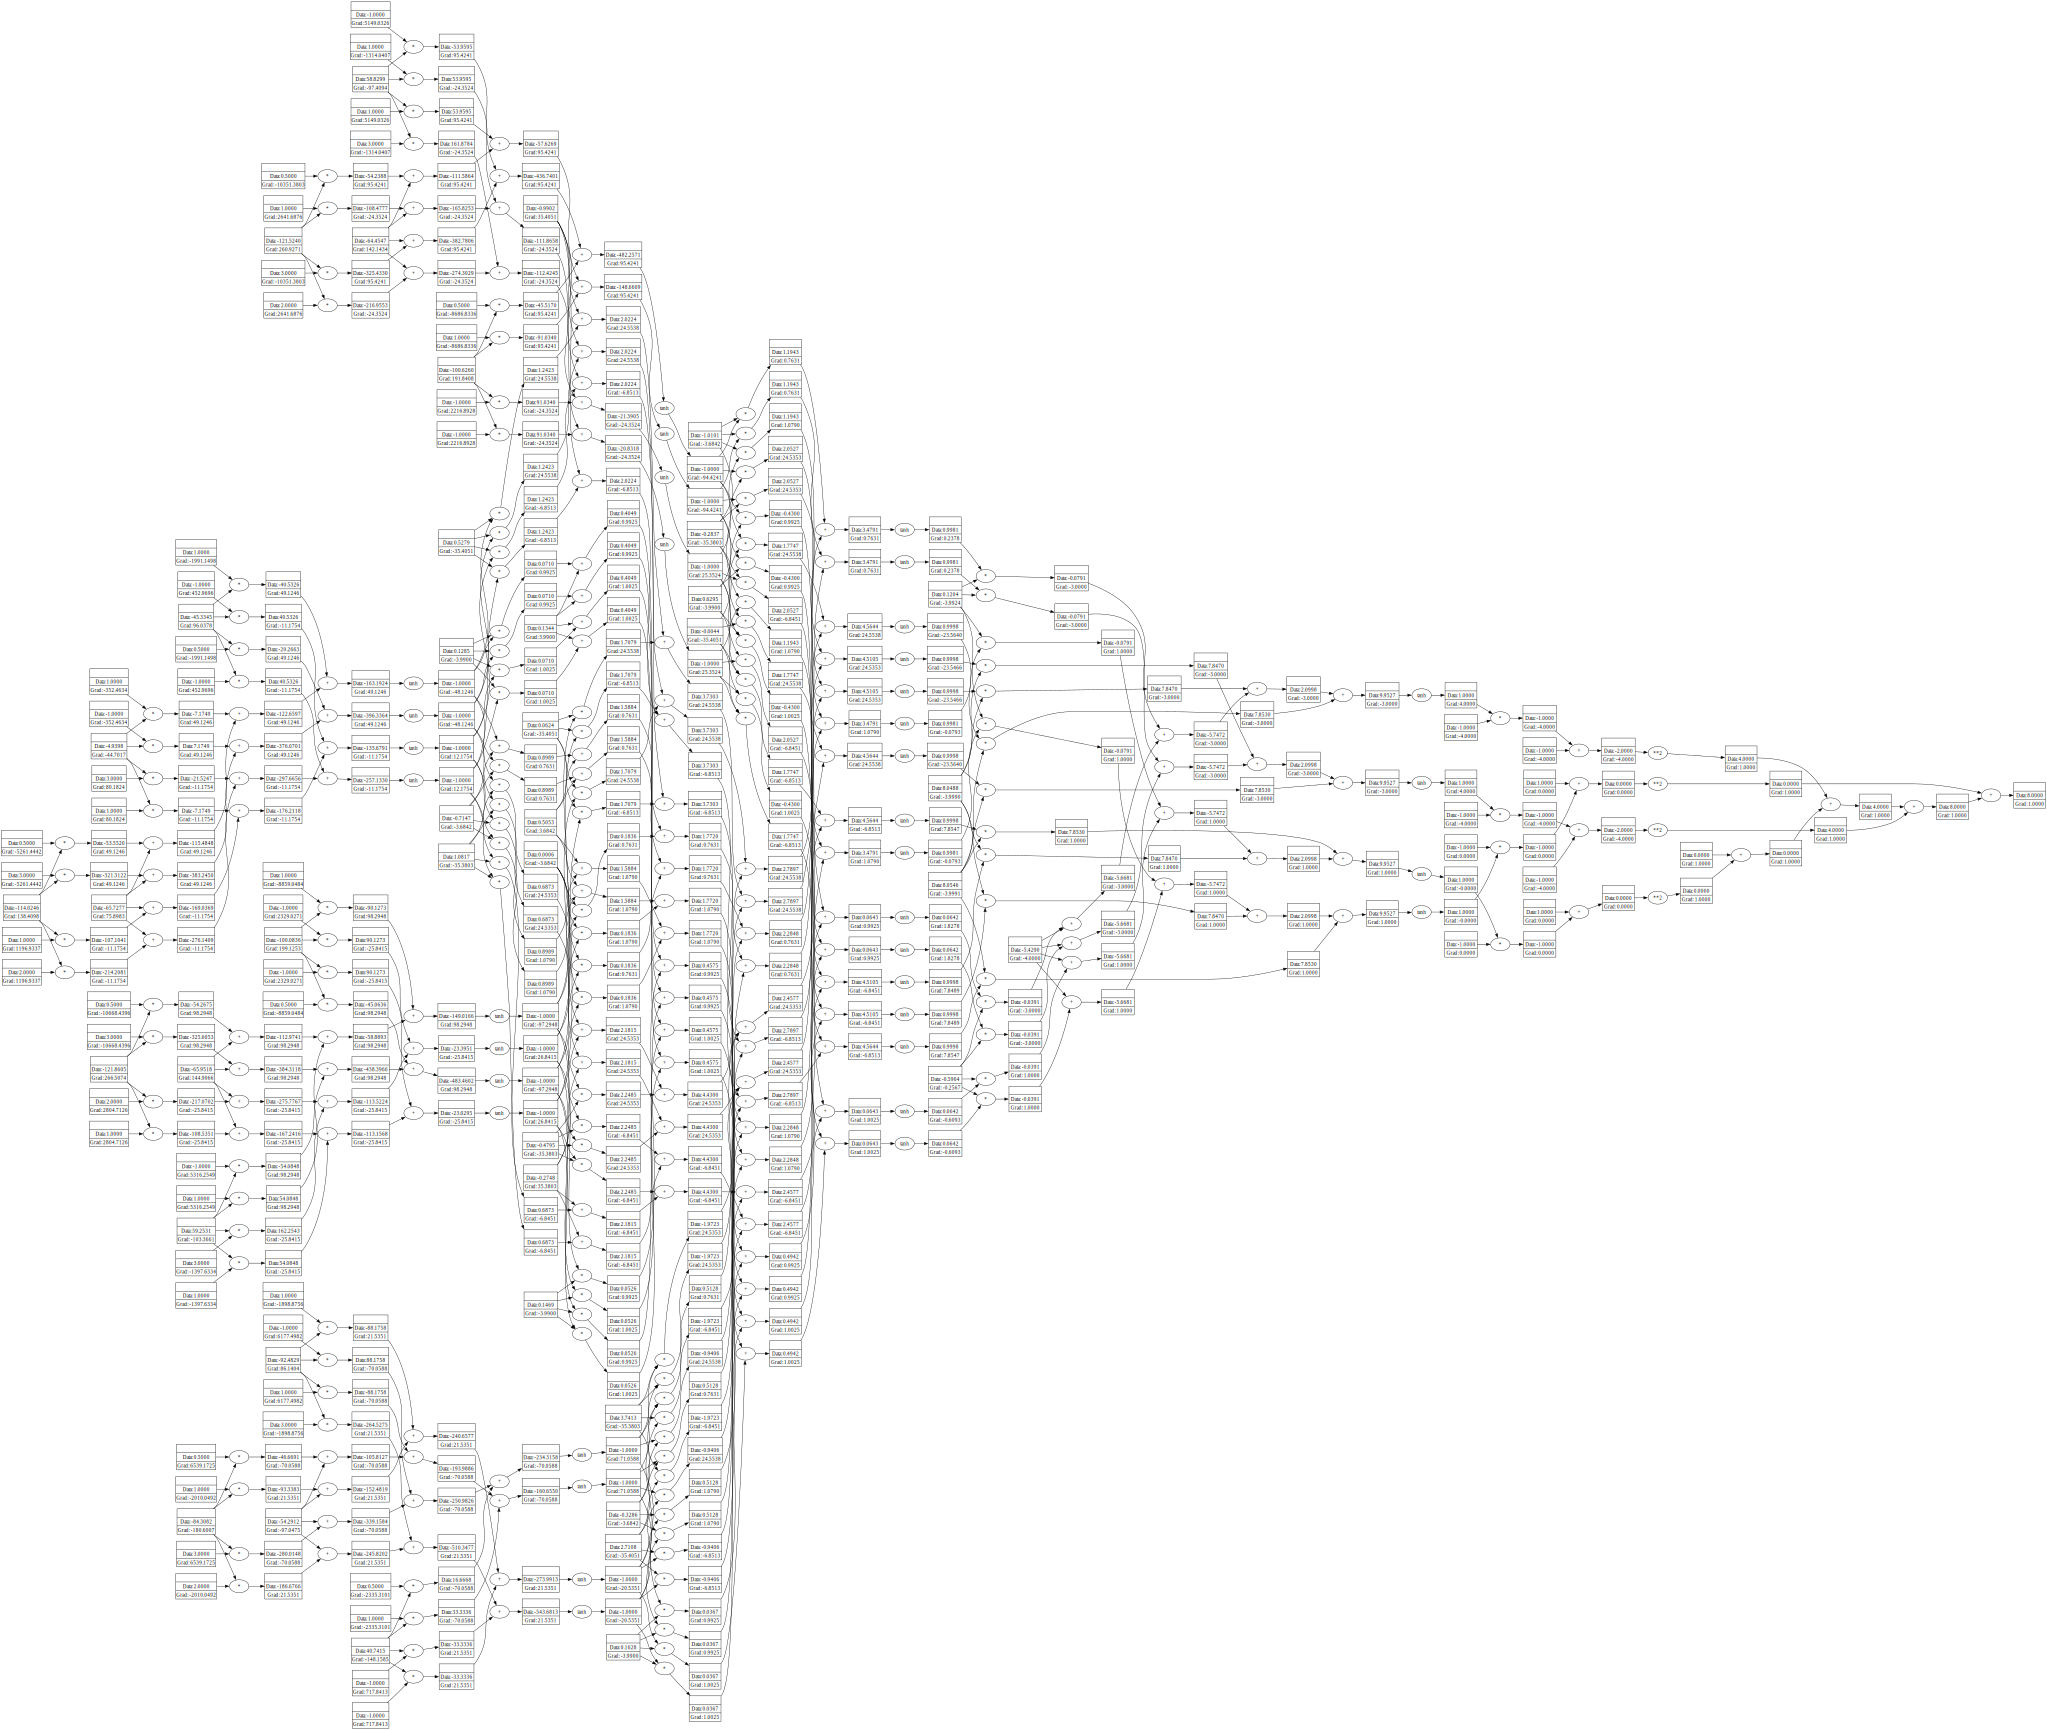

In [254]:

for k in range(30):
    # forward pass
    ypred = [n(x) for x in xs]
    
    loss = sum([(Value(y)-yhat)**2 for y, yhat in zip(ys, ypred)])

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k , loss.data)

# draw_dot(loss)

In [243]:
ypred

[Value(data=-0.9999999761449287),
 Value(data=-0.9999999760577528),
 Value(data=-0.9999999881531674),
 Value(data=-0.9999999791675728)]